# Latent Dirichlet Allocation and Sentiment Analysis Project
Welcome to my NLP Project. I wanted to get to know what notoriuos conspiracy theory lovers think, talk and feel about. To find out, I collected  13060
tweets with tag #conspiracytheory posted between 01.07-10.08.2020, processed text and analyzed topics using LDA, statistical model for discovering the abstract 'hidden' topics which occur in a collection of documents. I aslo analyzed sentiment of each tweet, infering some embedded emotions. Scroll down to see results!

## Imports

In [1]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle,re
from collections import Counter
import datetime 
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
sns.set()
pd.set_option('display.max_columns',None)
%matplotlib inline

#NLP related libraries
import nltk
from nltk.corpus import stopwords, wordnet 
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.util import ngrams
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pyLDAvis
import pyLDAvis.gensim  

#Scraper 
from twitterscraper import query_tweets

C:\Users\gorcz\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


## Scrape data from Twitter

In [2]:
def scrape_tweets(QUERY,BEGINDATE,ENDDATE,LANG,FILE_NAME='Tweets_conspiracytheory'):
    
    """
    Scrape tweets and return dataframe or load previosly scraped and saved dataframe
    
    Parameters:
    ----------
    QUERY : tagged word one wants to query 
    BEGINDATE,ENDDATE : start and end date in datetime format
    LANG : language

    """
    import os.path
    if os.path.isfile(FILE_NAME):        
        df =pd.read_pickle('Tweets_conspiracytheory')
        print('Loaded tweet extracts from file\n')
    else:
        print('Scraping tweets in progress...\n')
        tweets = query_tweets(QUERY, 
                                  begindate=BEGINDATE, 
                                  enddate=ENDDATE, 
                                  lang=LANG)
        df = pd.DataFrame([vars(x) for x in tweets])
        df.drop_duplicates(subset=['user_id','text'],inplace=True)
        df.reset_index(drop=True, inplace=True)
        # Save to pickle file
        df.to_pickle('Tweets_'+ QUERY) 
        print ('Tweets extracted and saved\n')
    return df
    

In [3]:
tweets_df=scrape_tweets('conspiracytheory', 
                                  BEGINDATE=datetime.date(2020, 7, 1), 
                                  ENDDATE=datetime.date(2020, 8, 10), 
                                  LANG='en')

Loaded tweet extracts from file



## EDA

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13060 entries, 10808 to 12129
Data columns (total 21 columns):
screen_name         13060 non-null object
username            13060 non-null object
user_id             13060 non-null object
tweet_id            13060 non-null object
tweet_url           13060 non-null object
timestamp           13060 non-null datetime64[ns]
timestamp_epochs    13060 non-null int64
text                13060 non-null object
text_html           13060 non-null object
links               13060 non-null object
hashtags            13060 non-null object
has_media           13060 non-null bool
img_urls            13060 non-null object
video_url           13060 non-null object
likes               13060 non-null int64
retweets            13060 non-null int64
replies             13060 non-null int64
is_replied          13060 non-null bool
is_reply_to         13060 non-null bool
parent_tweet_id     13060 non-null object
reply_to_users      13060 non-null object
dtypes:

In [5]:
tweets_df.head(4)

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,hashtags,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
10808,pro_skeptical,Berned again,1195924161744367617,1292611409138704384,/pro_skeptical/status/1292611409138704384,2020-08-09 23:59:10,1597017550,Trade wars and cold wars don't count. Actuall...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],[],False,[],,0,0,0,False,True,1292538556494348288,"[{'screen_name': 'anthonyzenkus', 'user_id': '..."
10793,journey2findkay,Im Doin Well...butrin 😉,941551585913479168,1292611272530259973,/journey2findkay/status/1292611272530259973,2020-08-09 23:58:37,1597017517,I cannot! These folks say it’s not a conspirac...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[https://www.cnn.com/videos/politics/2020/08/0...,"[makeitmakesense, CNN, CovidConspiracy]",False,[],,1,0,0,False,False,,[]
10794,conradhackett,Conrad Hackett,71643224,1292611143215853579,/conradhackett/status/1292611143215853579,2020-08-09 23:58:06,1597017486,48% of the Americans who didn't go to college ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[https://www.pewresearch.org/fact-tank/2020/07...,[],True,[https://pbs.twimg.com/media/EfBGmSOWkAIT0DR.png],,93,74,21,True,False,,[]
10795,ShitizenJourno,2020 Election in 0.5x A Presses,2349235814,1292611137452806144,/ShitizenJourno/status/1292611137452806144,2020-08-09 23:58:05,1597017485,It's not a crazed conspiracy theory if you get...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],[],False,[],,1,0,0,False,True,1292610640280842240,"[{'screen_name': 'KYFriedComrade', 'user_id': ..."


In [6]:
#extract from timestamp a day of week and hour 
tweets_df['day']=tweets_df['timestamp'].dt.dayofweek
tweets_df['hour']=tweets_df['timestamp'].dt.hour

In [7]:
#pivot table of tweet count by day and hour
pivot=pd.pivot_table(tweets_df, values='user_id', index=['hour'],
                    columns=['day'], aggfunc='count')
days={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Thursday', 5:'Saturday',
       6:'Sunday'}
pivot.rename(mapper=days, axis=1, inplace=True)
pivot.fillna(0,inplace=True)

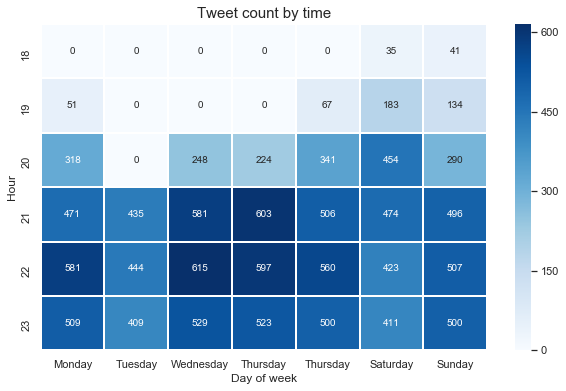

In [8]:
#count heatmap to check users' activity

fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(pivot, cmap='Blues',linewidths=1,annot=True,fmt='1.0f',ax=ax)
plt.title('Tweet count by time',size=15)
plt.xlabel('Day of week',size=12)
plt.ylabel('Hour',size=12)
ax.set_ylim(6,0);

Perhaps surprisingly- users tend to post only in the late evenings/at nights, 
there are no tweets before 18 o'clock and peak activity is reached after 21 o'clock.

Overall activity by week day is even, the only exeption is Tuesdays, when activity is noticebly lower.

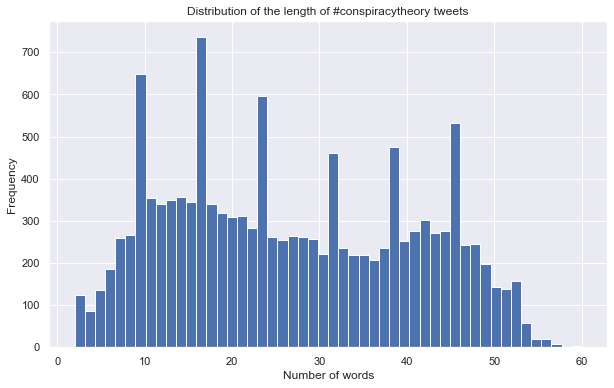

In [9]:
#calculate tweets' lenght- bimodal distribution

tweets_lenght= tweets_df['text'].str.split().apply(lambda x: len(x))
tweets_lenght.plot(kind='hist', figsize=(10,6), 
                   title="Distribution of the length of #conspiracytheory tweets",
                  bins=50)
plt.xlabel("Number of words");

## Text processing and mining 

In [10]:
def get_wordnet_pos(word):
    """
    Map POS (part of speech) tag of word string
    
    >>>get_wordnet_pos('sea')
    'n'
    
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def preprocess_text(text):  
    """
    Create cleaned and tokenized list of words
    
    >>>clean_text('Cats were sleeping')
    ['cat', 'sleep']
    
    """
    # Convert to lowercase
    cleaned = text.lower()
    # Remove numbers and special characters
    cleaned = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', cleaned).split() 
    # Remove short words with length < 2
    cleaned = [w for w in cleaned if len(w)>2]
    # Create lemmas taking into accout POS tag
    cleaned = [WordNetLemmatizer().lemmatize(w, get_wordnet_pos(w)) for w in cleaned]
    # Filter out English stop words and extra words from a list 
    stop_words = stopwords.words('english')
    stop_words=stop_words + ['from', 'subject', 're', 'edu', 'use','theory','twitter','com','conspiracytheory','conspiracy','people',
                            'via','youtube','still','time','feel','like','let','know','real','some','ever','see','please','tell','get','now',
                            'talk','make','would','aslo','believe']
    cleaned = [w for w in cleaned if w not in stop_words]
    return cleaned

In [12]:
def get_ngram(text,n=2):
    """
    Get a list of tokens and creates list of n-grams
    
    >>>get_ngram(['cat', 'dog','snake','frog'],n=2)
    ['cat dog', 'dog snake', 'snake frog']
    """
    tuples=[i for i in ngrams(text,n)]
    ngram_list=[" ".join(el) for el in tuples]
    return ngram_list

In [13]:
#process text data and get bi- and trigrams 
tweets_df['text_processed']=tweets_df['text'].map(preprocess_text)
tweets_df['bigrams']=tweets_df['text_processed'].apply(lambda x:get_ngram(x,2))
tweets_df['trigrams']=tweets_df['text_processed'].apply(lambda x:get_ngram(x,3))

In [14]:
tweets_df[['text','text_processed','bigrams','trigrams']].head(4)

,text,text_processed,bigrams,trigrams
10808,Trade wars and cold wars don't count. Actuall...,"[trade, war, cold, war, count, actually, dems,...","[trade war, war cold, cold war, war count, cou...","[trade war cold, war cold war, cold war count,..."
10793,I cannot! These folks say it’s not a conspirac...,"[cannot, folk, say, basically, say, makeitmake...","[cannot folk, folk say, say basically, basical...","[cannot folk say, folk say basically, say basi..."
10794,48% of the Americans who didn't go to college ...,"[american, college, powerful, intentionally, p...","[american college, college powerful, powerful ...","[american college powerful, college powerful i..."
10795,It's not a crazed conspiracy theory if you get...,"[craze, paid, say]","[craze paid, paid say]",[craze paid say]


In [15]:
def get_word_frequency(texts):
    """
    Create a word freqency dictionary 
    
    """
    words=[word for text in texts for word in text]
    word_frequency=Counter(words).most_common()
    return dict(word_frequency)

In [16]:
#word frequency preview for top 10 bigrams
word_frequency=get_word_frequency(tweets_df['bigrams'])
count=0
print('The most frequent 10 tokens:\n')
for k, v in word_frequency.items():
    count += 1
    print(k, v)
    if count>10:
        break

The most frequent 10 tokens:

right wing 189
wear mask 132
far right 119
deep state 113
sex traffic 91
bill gate 80
social medium 73
donald trump 70
rabbit hole 69
fake news 67
anti semitic 64


In [17]:
def word_cloud(word_frequency):
    """
    Creates an image  made of words, where size of a word shows how important it is e.g. how often it appears in a text
    
    """
    
    wordcloud = WordCloud(max_words=350, width=1200, height=1000, 
                      random_state=42, contour_width=3,
                      contour_color='firebrick',background_color="white")
    wordcloud.generate_from_frequencies(word_frequency)    
    plt.figure(figsize=(10,8)) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

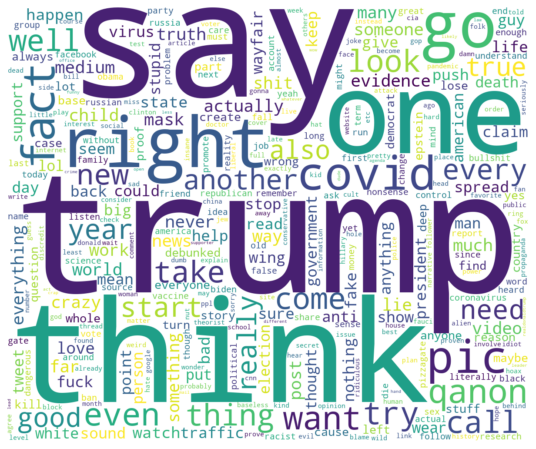

In [18]:
#unigram word cloud
word_cloud(get_word_frequency(tweets_df['text_processed']))

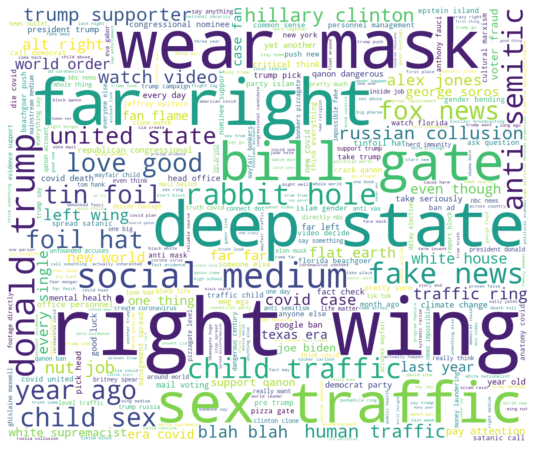

In [19]:
#bigram word cloud
word_cloud(get_word_frequency(tweets_df['bigrams']))

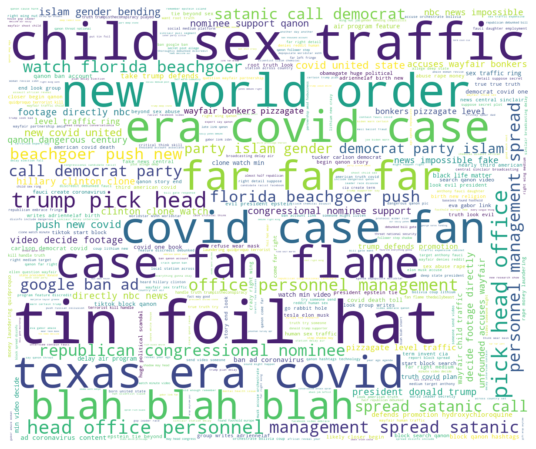

In [20]:
#trigram word cloud
word_cloud(get_word_frequency(tweets_df['trigrams']))

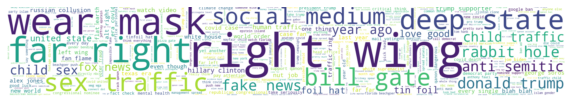

In [21]:
wordcloud = WordCloud(max_words=350, width=2500, height=400, 
                      random_state=42, contour_width=3,
                      contour_color='firebrick',background_color="white")
wordcloud.generate_from_frequencies(word_frequency)    
plt.figure(figsize=(10,8)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("WordCloud.jpg",dpi=300)

In [22]:
def get_dictionary(text,no_below=5, no_above=0.5, keep_n=3000):
    """
    Creates dicitonary of unique id for each word in the document and filters out extremes
    
    Parameters:
    ----------
    no_below : keep tokens which are contained in at least no_below documents

    no_above : keep tokens which are contained in no more than no_above documents 
    (fraction of total corpus : size, not an absolute number)
    
    keep_n :  keep only the first keep_n most frequent tokens

    Returns:
    -------
    dictionary : dictionary of words

    """
    dictionary = corpora.Dictionary(text)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)
    return dictionary

I decided to use bigrams for further modelling, as it seems most informative and generalized at the same time

In [23]:
#create dictionary for bigrams
dictionary=get_dictionary(tweets_df['bigrams'])
for v,k in dictionary.iteritems():
    print(v,k)
    if v>10:
        break

0 supporter say
1 trump supporter
2 pay attention
3 anyone say
4 anything else
5 right wing
6 far left
7 point say
8 white supremacist
9 money laundering
10 plain sight
11 cultural marxism


## LDA model building

In [24]:
def get_corpus(text,dictionary,corpus='BOW'):
    """
    Creates BOW (bag of words) model and transform it into TF-IDF (term frequency-inverse document frequency) 
    embedding (as an option)
    
    Parameters:
    ----------
    text : list of tokens
    dictionary : gensim dictionary object
    corpus : text representation, 'BOW' or ' TF-IDF'
    
    Returns:
    -------
    corpus : Vector representation of text

    """
    # Create bow model
    bow_corpus=[dictionary.doc2bow(doc) for doc in text]
    if corpus=='BOW':
        return bow_corpus
    # Create tf-idf model and then apply transformation to the entire corpus
    elif corpus=='TF-IDF':
        return models.TfidfModel(bow_corpus)[bow_corpus]
    else:
        print('Error: Make sure the typed corpus is either BOW or TF-IDF')

In [25]:
#get TF-IDF corpus
corpus=get_corpus(tweets_df['bigrams'],dictionary,corpus='TF-IDF')

In [26]:
def lda_model(num_topics, docs, corpus, dictionary,
                    num_passes=15,alpha='auto',eta='auto'): 
    """
    Compute LDA model

    Parameters:
    ----------
    num_topics : pre-defined number of topics 
    docs : dataframe with list of tokens
    corpus : gensim corpus
    dictionary : gensim dictionary
    num_passes : number of iterations
    alpha : a-priori belief for the each topics’ probability
    eta : a-priori belief on word probability

    Returns:
    -------
    trained_model : trained LDA model
    coherence_values : coherence valuee corresponding to the trained LDA model with respective number of topics
    """
    # Train LDA model
    trained_model = models.ldamodel.LdaModel(corpus=corpus, 
                                         num_topics=num_topics, 
                                         id2word=dictionary, 
                                         passes=num_passes, 
                                         alpha=alpha, 
                                         eta=eta,
                                         random_state=1)
    
    # Evaluate LDA model performance by computing Coherence Score
    lda_coherence= CoherenceModel(model=trained_model, texts=docs, 
                                         dictionary=dictionary, coherence='c_v')   
    coherence_value = lda_coherence.get_coherence()        
    print("Coherence value of LDA model with {} topics is {}".format(num_topics,round(coherence_value,3)))

    return trained_model, coherence_value

In [27]:
def coherence_values(docs, corpus, dictionary,
                     max_topics=20, start=3, step=1,
                     num_passes=15,alpha=0.001,eta='auto'):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    alpha : a-priori belief for the each topics’ probability
    eta : a-priori belief on word probability
    docs : dataframe with list of tokens
    dictionary : gensim dictionary
    corpus : gensim corpus
    max_topics,start,step : max num of topics, starting value and step

    Returns:
    -------
    plot : coherence values corresponding to the LDA model with respective number of topics
    """

    scores=[]
    topic_range=[]
    for num_topics in range(start,max_topics,step):

        lda_model_trained, coherence_value=lda_model(num_topics, docs, corpus, dictionary,
                    num_passes,alpha,eta)
        topic_range.append(num_topics)
        scores.append(coherence_value)
    
    plt.figure(figsize=(10,6))    
    plt.plot(topic_range,scores)    
    plt.title("LDA coherence values by number of topics")
    plt.xticks(topic_range)
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence value")

To find the optimal number of topics, I run multiple LDA models with different set of number of topics, in range of 4 to 20 and  picked the number that gave the highes coherence score.


Coherence value of LDA model with 3 topics is 0.692
Coherence value of LDA model with 4 topics is 0.723
Coherence value of LDA model with 5 topics is 0.735
Coherence value of LDA model with 6 topics is 0.743
Coherence value of LDA model with 7 topics is 0.752
Coherence value of LDA model with 8 topics is 0.734
Coherence value of LDA model with 9 topics is 0.738
Coherence value of LDA model with 10 topics is 0.742
Coherence value of LDA model with 11 topics is 0.729
Coherence value of LDA model with 12 topics is 0.742
Coherence value of LDA model with 13 topics is 0.739
Coherence value of LDA model with 14 topics is 0.741


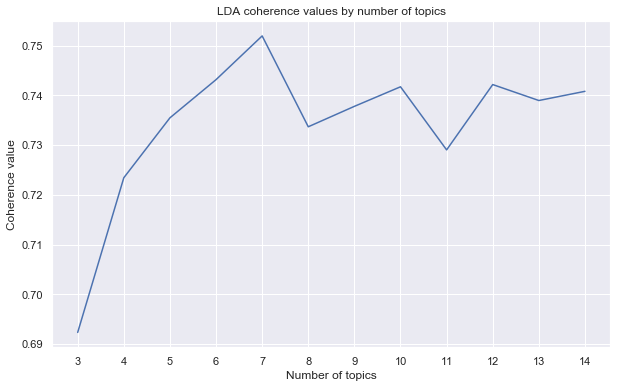

In [28]:
coherence_values(tweets_df['bigrams'], corpus, dictionary,
                     max_topics=15, start=3, step=1)

In [29]:
#optimal model
num_topics=7
lda_trained, coherence_value=lda_model(num_topics,tweets_df['bigrams'],corpus,dictionary,eta='auto',alpha=0.001)

Coherence value of LDA model with 7 topics is 0.752


Let's explore the words occuring in each of 7 topics and their relative weights.

In [30]:
lda_trained.show_topics(num_words=7)

[(0,
  '0.045*"bill gate" + 0.037*"rabbit hole" + 0.032*"child traffic" + 0.022*"flat earth" + 0.016*"voter fraud" + 0.016*"fact check" + 0.015*"world order"'),
 (1,
  '0.036*"anti semitic" + 0.034*"sex traffic" + 0.031*"far right" + 0.028*"watch video" + 0.021*"child sex" + 0.017*"alt right" + 0.016*"traffic ring"'),
 (2,
  '0.061*"right wing" + 0.034*"love good" + 0.030*"year ago" + 0.028*"donald trump" + 0.027*"fox news" + 0.017*"left wing" + 0.014*"one thing"'),
 (3,
  '0.028*"russian collusion" + 0.026*"alex jones" + 0.020*"nut job" + 0.016*"white supremacist" + 0.015*"every single" + 0.015*"far left" + 0.014*"climate change"'),
 (4,
  '0.069*"wear mask" + 0.044*"social medium" + 0.026*"human traffic" + 0.024*"tin foil" + 0.022*"anatomy covid" + 0.021*"foil hat" + 0.013*"reliable source"'),
 (5,
  '0.035*"deep state" + 0.016*"fake news" + 0.014*"year old" + 0.014*"good luck" + 0.013*"white house" + 0.012*"ask question" + 0.012*"critical think"'),
 (6,
  '0.023*"united state" + 0.0

Tag each document with a domintant topic, calculate the pecentage contribution in that document and get 6 keywords.

In [31]:
# Get the topic with the highest score
topics=[sorted(dict(i).items(), key=lambda x: x[1], reverse=True)[0][0] for i in lda_trained[corpus]]
# Get the highest score topic
topic_contribution=[sorted(dict(i).items(), key=lambda x: x[1], reverse=True)[0][1] for i in lda_trained[corpus]]
# Keywords
topic_keywords=[lda_trained.show_topics(num_words=6)[topic][1] for topic in topics]

In [32]:
# Concatenate with original df
extra_columns=list(zip(topics,topic_contribution,topic_keywords))
tweets_df=pd.concat([tweets_df.reset_index(drop=True),pd.DataFrame(extra_columns,columns=['topic number','topic contribution','topic keywords'])],
                axis=1)

## Get sentiment for of each tweet using VADER analyzer 

Before we run into topic interpretation, let's have a look at sentiment within each topics

In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [34]:
def sentiment_analyzer_scores(sentence):
    """
    Return a float for sentiment strength based on the input text.
    Positive values are positive valence, negative value are negative
    valence. It ranges from -1 to 1. 
    
    >>>sentiment_analyzer_scores("The TV is bad.")
    -0.5423
    
    """
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score['compound']


In [35]:
#calculate polarity
tweets_df['polarity']=tweets_df['text'].map(sentiment_analyzer_scores)

In [36]:
tweets_df[tweets_df['topic contribution']>0.5].groupby('topic number')['topic contribution','polarity'].mean()

,topic contribution,polarity
topic number,,
0,0.906166,-0.407187
1,0.906907,-0.417827
2,0.915354,-0.346581
3,0.902039,-0.426800
4,0.895673,-0.455170
5,0.924289,-0.407353
6,0.905021,-0.344779


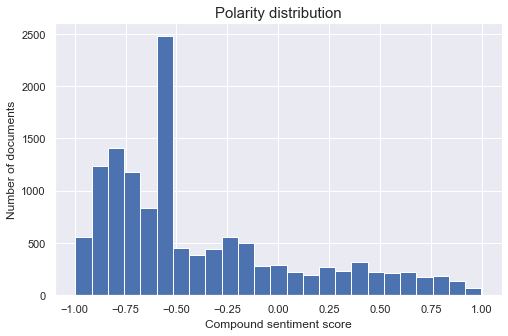

In [37]:
plt.figure(figsize=(8,5))
plt.hist(tweets_df['polarity'],bins=25);
plt.title("Polarity distribution",fontsize=15)
plt.xlabel("Compound sentiment score",fontsize=12)
plt.ylabel("Number of documents",fontsize=12);

Overall dominant polarity is negative, what matches with common sense and expectations. The least neative is topic 2 and 6, the most - 4.

## Visualize the topics with pyLDAvis tool
Package is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. 
There are two important metrics to interpret:

Saliency: it's measure of how much the term tells you about the topic

Relevance: it's a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic

The bubble size measures the relative importance of the topics, while the distance between the center of circles indicates the similarity between topics.


In [38]:
#import pyLDAvis
#import pyLDAvis.gensim  
#import matplotlib.pyplot as plt
#%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.228734 -0.192535       1        1  16.983887
2     -0.014495 -0.121897       2        1  14.575163
1     -0.230971  0.057488       3        1  14.488025
6      0.191548  0.286360       4        1  13.923166
0     -0.051543 -0.077923       5        1  13.583541
4     -0.071054  0.041661       6        1  13.270532
3     -0.052218  0.006847       7        1  13.175689, topic_info=    Category        Freq           Term       Total  loglift  logprob
136  Default   85.000000      wear mask   85.000000  30.0000  30.0000
253  Default   50.000000      bill gate   50.000000  29.0000  29.0000
5    Default  102.000000     right wing  102.000000  28.0000  28.0000
15   Default   47.000000  social medium   47.000000  27.0000  27.0000
106  Default   42.000000    rabbit hole   42.000000  26.0000  26.0000
..       ...         ...            ...         ...      ...      ...
53    Topic7    8.362424       find way    9.095892   1.9427  -4.8539
627   Topic7    8.271006    proven true    9.004334   1.9418  -4.8649
27    Topic7    8.217731     take trump    8.951002   1.9413  -4.8714
166   Topic7    8.153674   proven false    8.887085   1.9407  -4.8792
102   Topic7    7.735081   taylor swift    8.468214   1.9362  -4.9319

[256 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
1027      7  0.961588          actual fact
558       2  0.921246      actually happen
592       1  0.981149  actually interested
217       7  0.957910           alex jones
1089      6  0.959150     already debunked
...     ...       ...                  ...
125       2  0.980257             year ago
158       1  0.801110             year old
158       5  0.168655             year old
237       2  0.949199          yet another
887       6  0.961913        zero evidence

[245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 1, 5, 4])

In [39]:
#save to html
p = pyLDAvis.gensim.prepare(lda_trained, corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')